In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import pickle

In [2]:
# Load the user interaction data
user_data = pd.read_csv(r"C:\Users\hp\Desktop\Last Hope\cleaned_engagement_data3.csv")


In [ ]:

# Aggregate duplicate rows by summing 'time_spent'
user_data_aggregated = user_data.groupby(['UserID', 'CourseID'], as_index=False).agg({'TimeSpentONCourse': 'sum'})

# Normalize the interaction data for deep learning  
user_data_aggregated['TimeSpentONCourse'] = user_data_aggregated['TimeSpentONCourse'] / user_data_aggregated['TimeSpentONCourse'].max()


In [ ]:



# Define the number of unique users and content items
n_users = user_data_aggregated['UserID'].nunique()
n_items = user_data_aggregated['CourseID'].nunique()

# Create user and item mappings (to convert user_id and content_id into sequential numbers)
user_map = {UserID: i for i, UserID in enumerate(user_data_aggregated['UserID'].unique())}
item_map = {item_id: i for i, item_id in enumerate(user_data_aggregated['CourseID'].unique())}

# Apply mappings to the user_data_aggregated
user_data_aggregated['UserID'] = user_data_aggregated['UserID'].map(user_map)
user_data_aggregated['CourseID'] = user_data_aggregated['CourseID'].map(item_map)

# Split the data into training and test sets
train_data, test_data = train_test_split(user_data_aggregated, test_size=0.2, random_state=42)

# Rebuild the model architecture
n_users = 8123  
n_items = 7  





# Define the deep learning model (Neural Collaborative Filtering)
class NCFModel(tf.keras.Model):
    def __init__(self, n_users, n_items, embedding_dim=50):
        super(NCFModel, self).__init__()
        # User and item embedding layers
        self.user_embedding = tf.keras.layers.Embedding(input_dim=n_users, output_dim=embedding_dim)
        self.item_embedding = tf.keras.layers.Embedding(input_dim=n_items, output_dim=embedding_dim)
        
        # Neural network layers
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(32, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_input, item_input = inputs
        # Embedding lookup for users and items
        user_emb = self.user_embedding(user_input)
        item_emb = self.item_embedding(item_input)
        
        # Concatenate user and item embeddings
        concatenated = tf.concat([user_emb, item_emb], axis=-1)
        
        # Pass through fully connected layers
        x = self.fc1(concatenated)
        x = self.fc2(x)
        x = self.fc3(x)
        
        # Final output layer
        output = self.output_layer(x)
        return output

# Instantiate the model
embedding_dim = 50
ncf_model = NCFModel(n_users=n_users, n_items=n_items, embedding_dim=embedding_dim)

# Compile the model
ncf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare training data
train_user_input = train_data['UserID'].values
train_item_input = train_data['CourseID'].values
train_labels = (train_data['TimeSpentONCourse'] > 0).astype(np.float32).values   

# Train the model
ncf_model.fit([train_user_input, train_item_input], train_labels, epochs=50, batch_size=32)







Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4992 - loss: 0.6933
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7751 - loss: 0.5203
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0078
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.0938e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5369e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 9.0464e-05
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.1519e-05
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 4.2104e-05
Epoch 9/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0375e-05
Epoch 10/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.3849e-05
Epoch 11/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.8521e-05
Epoch 12/50
222/222 

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Performance Metrics:
Accuracy: 0.5653
Precision: 0.5723
Recall: 0.5403
F1-score: 0.5558
ROC-AUC Score: 0.6226

Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57       882
         1.0       0.57      0.54      0.56       894

    accuracy                           0.57      1776
   macro avg       0.57      0.57      0.57      1776
weighted avg       0.57      0.57      0.57      1776



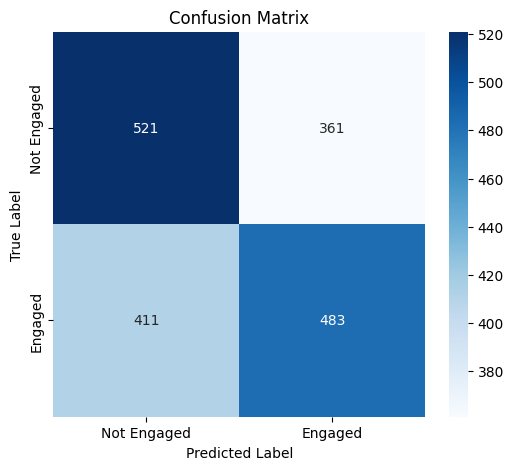

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare test data
test_user_input = test_data['UserID'].values
test_item_input = test_data['CourseID'].values
test_labels = (test_data['TimeSpentONCourse'] > 0).astype(np.float32).values   

# Predict probabilities for the test set
predicted_probs = ncf_model.predict([test_user_input, test_item_input])

# Convert probabilities to binary predictions (threshold = 0.5)
predicted_labels = (predicted_probs.flatten() > 0.5).astype(int)

# Compute performance metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
roc_auc = roc_auc_score(test_labels, predicted_probs.flatten())

# Print performance metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Classification report for detailed insights
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Engaged', 'Engaged'], yticklabels=['Not Engaged', 'Engaged'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:

# Define the directory and filename
directory_path = r"C:\Users\hp\Desktop\Last Hope"
model_filename = "ncf_model.h5"
model_path = os.path.join(directory_path, model_filename)

# Save the model
ncf_model.save(model_path)
print(f"Model saved at: {model_path}")

Model saved at: C:\Users\hp\Desktop\Last Hope\ncf_model.h5


In [20]:
user_map = {UserID: i for i, UserID in enumerate(user_data_aggregated['UserID'].unique())}
course_map = {CourseID: i for i, CourseID in enumerate(user_data_aggregated['CourseID'].unique())}


In [21]:
import pickle  
with open("user_map.pkl", "wb") as f:  
    pickle.dump(user_map, f)  
with open("course_map.pkl", "wb") as f:  
    pickle.dump(course_map, f)  


In [22]:
print(n_users)
print(n_items)

8123
7


In [ ]:
# Define your model with correct values
n_users = 8123   
n_items = 7    

model = NCFModel(n_users=n_users, n_items=n_items)

# Compile and train your model  
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save the model correctly
model.save("ncf_model.h5")


In [ ]:
model = NCFModel(n_users, n_items)  
model.compile(optimizer="adam", loss="binary_crossentropy")  

# Save the model correctly
model.save("ncf_model.keras")   
